In [2]:
%%html
<a target="_blank" href="https://colab.research.google.com/github/ftavella/when_should_school_start/blob/main/When_Should_School_Start.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Welcome to the sheet

Make a copy and interact with this to understand school start times from a circadian perspective

Instructions: under construction
Notes: Current estimates from simulations are biased towards the default initial condition. TODO: Add an equilibration simulation to get rid of this bias.

In [ ]:
#@title Setup Environment
%%capture
!pip install dash
!pip install astral
!pip install pysolar
!pip install timezonefinder
!pip uninstall -y circadian
!pip install dash-bootstrap-components
!pip install --upgrade git+https://github.com/ftavella/circadian.git@school_light_schedule

Found existing installation: circadian 1.0.2
Uninstalling circadian-1.0.2:
  Successfully uninstalled circadian-1.0.2
  Cloning https://github.com/ftavella/circadian.git (to revision school_light_schedule) to /tmp/pip-req-build-c829a8av
  Running command git clone --filter=blob:none --quiet https://github.com/ftavella/circadian.git /tmp/pip-req-build-c829a8av
  Running command git checkout -b school_light_schedule --track origin/school_light_schedule
  Switched to a new branch 'school_light_schedule'
  branch 'school_light_schedule' set up to track 'origin/school_light_schedule'.
  Resolved https://github.com/ftavella/circadian.git to commit 6e53092fd5e524d9748c490ca40ae140f00fbc61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circadian: filename=circadian-1.0.2-py3-none-any.whl size=46659 sha256=3098a1bc92ea131a050f1ae002288fb826e357a73f89450181bb9237619c4b16
  Stored in direct

In [ ]:
#@title Import Libraries
%%capture
import dash
import pytz
import numpy as np
import pandas as pd
import pysolar as ps
from astral.sun import sun
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from astral import LocationInfo
from scipy.stats import circmean
from geopy.geocoders import Nominatim
import dash_bootstrap_components as dbc
from timezonefinder import TimezoneFinder
from circadian.lights import LightSchedule
from dash import dcc, html, Input, Output, State, callback
from circadian.models import Skeldon23, DynamicalTrajectory

In [ ]:
#@title Helper Functions
def circadian_modulation_of_sleep(model, trajectory):
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    linear_term = model.c20 + model.alpha21 * xc + model.alpha22 * x
    quadratic_term = model.beta21 * xc * xc + model.beta22 * xc * x + model.beta23 * x * x
    C = linear_term + quadratic_term
    return C


def H_thresholds(model, trajectory):
    C = circadian_modulation_of_sleep(model, trajectory)
    H_plus = model.H0 + 0.5 * model.Delta + model.ca * C
    H_minus = model.H0 - 0.5 * model.Delta + model.ca * C
    return H_plus, H_minus


def calculate_sleep_onset_and_offset(time, sleep):
    sleep_onset_idx = np.where(np.diff(sleep) == 1)[0]
    sleep_offset_idx = np.where(np.diff(sleep) == -1)[0]
    if sleep_offset_idx[0] < sleep_onset_idx[0]:
        sleep_offset_idx = sleep_offset_idx[1:]
    if sleep_onset_idx[-1] > sleep_offset_idx[-1]:
        sleep_onset_idx = sleep_onset_idx[:-1]
    min_length = min(len(sleep_onset_idx), len(sleep_offset_idx))
    sleep_onset_idx = sleep_onset_idx[:min_length]
    sleep_offset_idx = sleep_offset_idx[:min_length]
    return time[sleep_onset_idx], time[sleep_offset_idx]


def calculate_sleep_duration(time, sleep):
    sleep_onset, sleep_offset = calculate_sleep_onset_and_offset(time, sleep)
    sleep_duration = sleep_offset - sleep_onset
    return sleep_duration


def get_city_info(city_name):
    """
    Gets the latitude, longitude, and time zone of a given city.

    Args:
        city_name: The name of the city.

    Returns:
        A dictionary containing the latitude, longitude, and time zone of the city,
        or None if the city is not found or an error occurs.
    """
    geolocator = Nominatim(user_agent="app")
    tf = TimezoneFinder()

    try:
        location = geolocator.geocode(city_name)
        if location:
            latitude = location.latitude
            longitude = location.longitude
            timezone = tf.timezone_at(lng=longitude, lat=latitude)

            return {
                "latitude": latitude,
                "longitude": longitude,
                "timezone": timezone,
            }
        else:
            print(f"City '{city_name}' not found.")
            return None
    except Exception as e:
        print(f"Error getting city info: {e}")
        return None


def get_sunrise_sunset(latitude, longitude, timezone, datetime_value):
    """
    Calculates sunrise and sunset times for a given latitude, longitude, and timezone.

    Args:
        latitude: Latitude of the location.
        longitude: Longitude of the location.
        timezone: Timezone string (e.g., "US/Pacific", "Europe/London").

    Returns:
        A tuple containing sunrise and sunset times as hours of the day in local time,
        or None if an error occurs.
    """
    try:
        # Create a LocationInfo object with the specified timezone
        city = LocationInfo("Example City", "Region", timezone, latitude, longitude)

        # Calculate sunrise and sunset for today
        s = sun(city.observer, date=datetime_value)

        # Convert sunrise and sunset to local time
        local_tz = pytz.timezone(timezone)
        sunrise_local = s['sunrise'].astimezone(local_tz)
        sunset_local = s['sunset'].astimezone(local_tz)

        # Extract hour of day
        sunrise_hour = sunrise_local.hour
        sunset_hour = sunset_local.hour

        return sunrise_hour, sunset_hour

    except Exception as e:
        print(f"Error calculating sunrise/sunset: {e}")
        return None, None


def get_direct_sunlight_lux(datetime_value, timezone, latitude, longitude,
                            wm2_to_lux_conversion_factor=120):
    """
    Calculates the direct sunlight illuminance (lux) at a given location and time.

    Args:
        date: The date and time for which to calculate the illuminance.
        timezone: The timezone of the location.
        latitude: The latitude of the location.
        longitude: The longitude of the location.

    Returns:
        The direct sunlight illuminance in lux, or None if an error occurs.
    """
    try:
        timezone_aware_datetime = pytz.timezone(timezone).localize(datetime_value)
        # Get the solar elevation angle for the location and time
        altitude_deg = ps.solar.get_altitude(latitude, longitude, timezone_aware_datetime)
        # Calculate the illuminance in lux
        illuminance = ps.solar.radiation.get_radiation_direct(datetime_value, altitude_deg)
        lux = illuminance * wm2_to_lux_conversion_factor  # Convert W/m^2 to lux
        return lux

    except Exception as e:
        print(f"Error calculating direct sunlight lux: {e}")
        return None


def get_outdoor_light_parameters(city_name, datetime_value, dst_in_effect):
    location_dict = get_city_info(city_name)
    if location_dict is None:
        return None
    else:
        latitude = location_dict["latitude"]
        longitude = location_dict["longitude"]
        timezone = location_dict["timezone"]

        # Get sunrise and sunset times
        sunrise_hour, sunset_hour = get_sunrise_sunset(latitude, longitude, timezone, datetime_value)
        if sunrise_hour is None or sunset_hour is None:
            return None

        direct_sunlight_lux = get_direct_sunlight_lux(datetime_value, timezone, latitude, longitude) # Adjust for DST?

        if dst_in_effect:
            # Adjust for daylight saving time
            sunrise_hour += 1
            sunset_hour += 1

        return {
            "latitude": latitude,
            "longitude": longitude,
            "timezone": timezone,
            "sunrise_hour": sunrise_hour,
            "sunset_hour": sunset_hour,
            "direct_sunlight_lux": direct_sunlight_lux,
        }


def symlog(x, linthresh=1.0):
    return np.sign(x) * np.log1p(np.abs(x) / linthresh)


def simulate_school_start_time(school_start_time: float, lux_params: dict, dt=0.01, weeks_to_simulate=4):
    time = np.arange(0, 24 * 7 * weeks_to_simulate, dt)

    light_schedule_parameters = {
        'school_start_time': school_start_time,
        'school_prep_duration': 1.0,
        'school_duration': 6.0,
        'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
        'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
        'outdoor_light_sunset_time': lux_params["sunset_hour"],
    }

    parameters = {
        'S0': 0,
        'forced_wakeup_light_threshold': 100.0, # half the default prep time lux
        'forced_wakeup_weekday_only': True,
    }

    model = Skeldon23(params=parameters)
    trajectory = model.integrate(time, input=LightSchedule.School(**light_schedule_parameters)(time))

    sleep = model.sleep_state
    # circadian_state = trajectory.states[:, 0]
    # sleep_homeostat = trajectory.states[:, 3]
    # H_plus, H_minus = H_thresholds(model, trajectory)

    sleep_onset, sleep_offset = calculate_sleep_onset_and_offset(time, sleep)
    sleep_duration = calculate_sleep_duration(time, sleep)

    return time, sleep, sleep_onset, sleep_offset, sleep_duration

In [ ]:
#@title Run application
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

# Location and date selection
location_DST_row = dbc.Row([
    dbc.Col([ # Location text
        dbc.Label("Enter a city name"),
    ], width=2, align="center"),
    dbc.Col([ # Location input
        dbc.Input(id="location", type="text", placeholder="Enter a city name", value="Chronia"),
    ], width=2),
    dbc.Col([ # Date text
        dbc.Label("Date"),
    ], width=1, align="center"),
    dbc.Col([ # Date input
        dcc.DatePickerSingle(id="date", date=datetime.now(), display_format="YYYY-MM-DD"),
    ], width=2, align="center", className="dash-bootstrap"),
    dbc.Col([ # DST
        dbc.Checklist(id="dst", options=[{"label": "Daylight Savings Time", "value": 1}], value=[],
                      switch=True),
    ], width=2, align="center"),
    dbc.Col([ # Calculate light intensity button
        dbc.Button(
            "Calculate light intensity",
            id="calculate_lights", color="primary"),
    ], width=3, align="center"),
], className="mt-3")

# Light plots
light_weekday_weekend_plots = dbc.Spinner(color="primary", children=
    dbc.Row([
        dbc.Col([ # Weekday plot
            dcc.Graph(figure=px.line(), id="weekday_light_plot"),
        ], width=6),
        dbc.Col([ # Weekend plot
            dcc.Graph(figure=px.line(), id="weekend_light_plot"),
        ], width=6),
    ])
)

# School start time selection and button to run single simulation
school_start_time_row = dbc.Row([
    dbc.Col([ # School start time text
        dbc.Label("School start time"),
    ], width=2, align="center"),
    dbc.Col([ # School start time input, as a number between 0 and 24
        dbc.Input(id="school_start_time", type="time", value="08:30"),
    ], width=2, align="center"),
    dbc.Col([ # Run simulation button
        dbc.Button("Run Simulation", id="run_simulation", color="primary"),
    ], width=3, align="center"),
], className="mt-3")

# Typical weekday plot, typical weekend plot, and text zone to display average sleep metrics
simulation_result_row = dbc.Spinner(color="primary", children=
    dbc.Row([
        dbc.Col([ # Typical weekday plot
            dcc.Graph(figure=px.line(), id="typical_weekday_plot"),
        ], width=5),
        dbc.Col([ # Typical weekend plot
            dcc.Graph(figure=px.line(), id="typical_weekend_plot"),
        ], width=5),
        dbc.Col([ # Average sleep metrics
            dbc.Row([
                html.H6("Average wake up time:", id="average_wake_up_time"),
            ]),
            dbc.Row([
                html.H6("Average fall asleep time:", id="average_sleep_onset"),
            ]),
            dbc.Row([
                html.H6("Average sleep duration (overall):", id="average_sleep_duration"),
            ]),
            dbc.Row([
                html.H6("Average sleep duration (weekdays):", id="average_sleep_duration_weekdays"),
            ]),
            dbc.Row([
                html.H6("Average sleep duration (weekends):", id="average_sleep_duration_weekends"),
            ]),

        ], width=2, align="center"),
    ])
)

# Row with range selection of school start times and the number of simulations to run
school_start_time_range_row = dbc.Row([
    dbc.Col([ # School start time range text
        dbc.Label("School start time range"),
    ], width=2, align="center"),
    dbc.Col([ # School start time range input
        dcc.RangeSlider(id="school_start_time_range", min=0, max=24, step=0.5,
                        # className="dash-bootstrap",
                        value=[6, 12],
                        marks={0: '0', '12': '12', 24: '24'},
                        allowCross=False, tooltip={"always_visible": True}),
    ], width=2, align="center"),
    dbc.Col([ # Number of simulations text
        dbc.Label("Number of simulations"),
    ], width=2, align="center"),
    dbc.Col([ # Number of simulations input
        dbc.Input(id="num_simulations", type="number", placeholder="Enter a number",
                  value=7, min=1, max=100),
    ], width=2, align="center"),
    dbc.Col([ # Run multiple simulations button
        dbc.Button("Run Multiple Simulations", id="run_multiple_simulations", color="primary"),
    ], width=3, align="center"),
], className="mt-3")

# Row with three plots for the multiple simulations: average sleep duration, weekday and weekend sleep duration, and average weekday
multiple_simulations_plots = dbc.Spinner(color="primary", children=
    dbc.Row([
        dbc.Col([ # Average sleep duration plot
            dcc.Graph(figure=px.line(), id="average_sleep_duration_plot"),
        ], width=4),
        dbc.Col([ # Average weekday and weekend sleep duration plot
            dcc.Graph(figure=px.line(), id="average_weekday_weekend_sleep_duration_plot"),
        ], width=4),
        dbc.Col([ # Typical weekday plot for all simulations
            dcc.Graph(figure=px.line(), id="typical_weekday_multiple_simulations_plot"),
        ], width=4),
    ])
)

app.layout = dbc.Container([
    location_DST_row,
    light_weekday_weekend_plots,
    school_start_time_row,
    simulation_result_row,
    school_start_time_range_row,
    multiple_simulations_plots,
], fluid=True, style={"padding": "20"})

# Callback to update the weekday and weekend light plots
@app.callback(
    [Output("weekday_light_plot", "figure"),
     Output("weekend_light_plot", "figure")],
    [Input("calculate_lights", "n_clicks")],
    [State("location", "value"),
     State("date", "date"),
     State("dst", "value")],
     prevent_initial_call=False,
)
def update_light_plots(n_clicks, location, datetime_value, dst,
                       default_time_to_calculate_lux="-12:00:00"):
    date = datetime_value.split("T")[0] + default_time_to_calculate_lux
    datetime_value = datetime.strptime(date, "%Y-%m-%d-%H:%M:%S")
    print(f"Gathering light information for {location} on {datetime_value}")
    dst_in_effect = bool(dst)
    try:
        lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)
    except:
        return px.line(), px.line()

    if lux_params is None:
        print("Error getting light parameters.")
        return px.line(), px.line()
    elif any(value is None for value in lux_params.values()):
        print("Error getting light parameters.")
        return px.line(), px.line()

    time = np.arange(0, 24*7, 0.01)
    light_schedule_parameters = {
        'school_start_time': 8.5,
        'school_prep_duration': 1.0,
        'school_duration': 6.0,
        'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
        'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
        'outdoor_light_sunset_time': lux_params["sunset_hour"],
    }

    school_schedule = LightSchedule.School(**light_schedule_parameters)
    school_light = school_schedule(time)

    symlog_school_light = symlog(school_light)
    y_ticks = np.array([0, 1, 10, 100, 1000, 10000, 150000])
    y_ticks_symlog = symlog(y_ticks)
    y_tick_labels = [f"{int(y)}" for y in y_ticks]

    weekday_mask = (time >= 0) & (time < 24)
    weekend_mask = (time >= 24*5) & (time < 24*6)

    hover_data = {'Time': True, 'Light': True, 'SymLogLight': False}
    hover_template = "<b>Time</b>: %{customdata[0]:.2f} hour<br><b>Light</b>: %{customdata[1]:.2f} lux"


    weekday_light_fig = px.line(pd.DataFrame({'Time': time[weekday_mask], 'Light': school_light[weekday_mask],
                                              'SymLogLight': symlog_school_light[weekday_mask]}),
                                x='Time', y='SymLogLight', title='Weekday Light Schedule',
                                hover_data=hover_data, custom_data=['Time', 'Light'])
    weekend_light_fig = px.line(pd.DataFrame({'Time': time[weekend_mask], 'Light': school_light[weekend_mask],
                                              'SymLogLight': symlog_school_light[weekend_mask]}),
                                x='Time', y='SymLogLight', title='Weekend Light Schedule',
                                hover_data=hover_data, custom_data=['Time', 'Light'])

    # Plot layout adjustments
    weekday_light_fig.update_layout(showlegend=False, xaxis_title="Time (hour)", yaxis_title="Light intensity (lux)",
                                    yaxis=dict(tickvals=y_ticks_symlog, ticktext=y_tick_labels))
    weekend_light_fig.update_layout(showlegend=False, xaxis_title="Time (hour)", yaxis_title="Light intensity (lux)",
                                    yaxis=dict(tickvals=y_ticks_symlog, ticktext=y_tick_labels))

    weekday_light_fig.update_traces(hovertemplate=hover_template)

    return weekday_light_fig, weekend_light_fig

# Callback to run a single simulation and update the typical weekday and weekend plots
@app.callback(
    [Output("typical_weekday_plot", "figure"),
     Output("typical_weekend_plot", "figure"),
     Output("average_wake_up_time", "children"),
     Output("average_sleep_onset", "children"),
     Output("average_sleep_duration", "children"),
     Output("average_sleep_duration_weekdays", "children"),
     Output("average_sleep_duration_weekends", "children")
     ],
    [Input("run_simulation", "n_clicks")],
    [State("school_start_time", "value"),
     State("location", "value"),
     State("date", "date"),
     State("dst", "value")],
     prevent_initial_call=True,
)
def run_single_simulation(n_clicks, school_start_time, location, datetime_value, dst):
    date = datetime_value.split("T")[0] + "-12:00:00"
    datetime_value = datetime.strptime(date, "%Y-%m-%d-%H:%M:%S")
    print(f"Running simulation at {location}, school start time: {school_start_time}, date: {datetime_value.date()}")
    dst_in_effect = bool(dst)
    try:
        lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)
    except:
        return px.line(), px.line(), px.line(), px.line(), px.line()

    if lux_params is None:
        print("Error getting light parameters.")
        return px.line(), px.line(), px.line(), px.line(), px.line()
    elif any(value is None for value in lux_params.values()):
        print("Error getting light parameters.")
        return px.line(), px.line(), px.line(), px.line(), px.line()

    start_time_float = float(school_start_time.split(":")[0]) + float(school_start_time.split(":")[1]) / 60.0

    time, sleep, sleep_onset, sleep_offset, sleep_duration = simulate_school_start_time(start_time_float, lux_params)

    weekday_sleep_duration = []
    weekend_sleep_duration = []
    for idx, onset in enumerate(sleep_onset):
        if (onset / 24.0) % 7 < 5:
            weekday_sleep_duration.append(sleep_duration[idx])
        else:
            weekend_sleep_duration.append(sleep_duration[idx])

    average_sleep_onset = circmean(sleep_onset, high=24)
    average_sleep_offset = circmean(sleep_offset, high=24)
    average_sleep_duration = np.mean(sleep_duration)
    average_sleep_weekday = np.mean(weekday_sleep_duration)
    average_sleep_weekend = np.mean(weekend_sleep_duration)

    sleep_onset_text = f"Average wake up time: {average_sleep_offset:.2f} hours"
    sleep_offset_text = f"Average fall asleep time: {average_sleep_onset:.2f} hours"
    sleep_overall_text = f"Average sleep duration (overall): {average_sleep_duration:.2f} hours"
    sleep_weekday_text = f"Average sleep duration (weekdays): {average_sleep_weekday:.2f} hours"
    sleep_weekend_text = f"Average sleep duration (weekends): {average_sleep_weekend:.2f} hours"


    last_monday_start = 24 * 7 * 3
    last_monday_end = last_monday_start + 24
    last_saturday_start = 24 * 7 * 3 + 24 * 5
    last_saturday_end = last_saturday_start + 24
    weekday_mask = (time >= last_monday_start) & (time < last_monday_end)
    weekend_mask = (time >= last_saturday_start) & (time < last_saturday_end)

    hover_data = {'Time': True, 'Sleep': True}
    hover_template = "<b>Time</b>: %{customdata[0]:.2f} hour<br><b>Sleep</b>: %{customdata[1]:.2f}"

    weekday_sleep_fig = px.line(pd.DataFrame({'Time': time[weekday_mask] - last_monday_start, 'Sleep': sleep[weekday_mask]}),
                                x='Time', y='Sleep', title='Typical Weekday Sleep Schedule',
                                hover_data=hover_data, custom_data=['Time', 'Sleep'])
    weekend_sleep_fig = px.line(pd.DataFrame({'Time': time[weekend_mask] - last_saturday_start, 'Sleep': sleep[weekend_mask]}),
                                x='Time', y='Sleep', title='Typical Weekend Sleep Schedule',
                                hover_data=hover_data, custom_data=['Time', 'Sleep'])
    # Plot layout adjustments
    weekday_sleep_fig.update_layout(showlegend=False, xaxis_title="Time (hour)", yaxis_title="Sleep state",
                                    yaxis=dict(tickvals=[0, 1], ticktext=['Awake', 'Sleep']))
    weekend_sleep_fig.update_layout(showlegend=False, xaxis_title="Time (hour)", yaxis_title="Sleep state",
                                    yaxis=dict(tickvals=[0, 1], ticktext=['Awake', 'Sleep']))
    weekday_sleep_fig.update_traces(hovertemplate=hover_template)
    weekend_sleep_fig.update_traces(hovertemplate=hover_template)

    return weekday_sleep_fig, weekend_sleep_fig, sleep_offset_text, sleep_onset_text, sleep_overall_text, sleep_weekday_text, sleep_weekend_text


# Callback to run multiple simulations and update the average sleep duration vs. school start time, weekday and weekend sleep duration vs. school start time, and average weekday sleep plots
@app.callback(
    [Output("average_sleep_duration_plot", "figure"),
     Output("average_weekday_weekend_sleep_duration_plot", "figure"),
     Output("typical_weekday_multiple_simulations_plot", "figure")],
    [Input("run_multiple_simulations", "n_clicks")],
    [State("school_start_time_range", "value"),
     State("num_simulations", "value"),
     State("location", "value"),
     State("date", "date"),
     State("dst", "value")],
     prevent_initial_call=True,
)
def run_multiple_simulations(n_clicks, school_start_time_range, num_simulations, location, datetime_value, dst):
    date = datetime_value.split("T")[0] + "-12:00:00"
    datetime_value = datetime.strptime(date, "%Y-%m-%d-%H:%M:%S")
    print(f"Running {num_simulations} simulations at {location}, school start time range: {school_start_time_range}, date: {datetime_value.date()}")
    dst_in_effect = bool(dst)
    try:
        lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)
    except:
        return px.line(), px.line(), px.line()

    if lux_params is None:
        print("Error getting light parameters.")
        return px.line(), px.line(), px.line()
    elif any(value is None for value in lux_params.values()):
        print("Error getting light parameters.")
        return px.line(), px.line(), px.line()

    school_start_times = np.linspace(school_start_time_range[0], school_start_time_range[1], num_simulations)


    sleep_duration_overall = []
    sleep_duration_weekday = []
    sleep_duration_weekend = []
    sleep_state_weekdays = []
    time_weekdays = []

    for school_start_time in school_start_times:
        print(f'Simulating for school start time: {school_start_time}')
        time, sleep, sleep_onset, sleep_offset, sleep_duration = simulate_school_start_time(school_start_time, lux_params)
        weekday_sleep_duration = []
        weekend_sleep_duration = []
        for idx, onset in enumerate(sleep_onset):
            if (onset / 24.0) % 7 < 5:
                weekday_sleep_duration.append(sleep_duration[idx])
            else:
                weekend_sleep_duration.append(sleep_duration[idx])


        last_monday_start = 24 * 7 * 3
        last_monday_end = last_monday_start + 24
        weekday_mask = (time >= last_monday_start) & (time < last_monday_end)

        sleep_on_weekday = sleep[weekday_mask]
        sleep_state_weekdays.append(sleep_on_weekday)
        sleep_duration_overall.append(np.mean(sleep_duration))
        sleep_duration_weekday.append(np.mean(weekday_sleep_duration))
        sleep_duration_weekend.append(np.mean(weekend_sleep_duration))
        time_weekdays.append(time[weekday_mask] - last_monday_start)

    sleep_duration_overall_fig = px.line(x=school_start_times, y=sleep_duration_overall, title='Average Sleep Duration vs. School Start Time',
                                            labels={'x': 'School start time', 'y': 'Average sleep duration (hours)'})
    sleep_duration_overall_fig.update_traces(mode='lines+markers')

    duration_weekday_weekend_df = pd.DataFrame({'School start time': school_start_times, 'Sleep duration weekday': sleep_duration_weekday,
                                                'Sleep duration weekend': sleep_duration_weekend})
    sleep_duration_weekday_weekend_fig = px.line(duration_weekday_weekend_df, x='School start time', y=['Sleep duration weekday', 'Sleep duration weekend'],
                                                title='Average Sleep Duration vs. School Start Time',
                                                labels={'x': 'School start time', 'y': 'Average sleep duration (hours)'})
    sleep_duration_weekday_weekend_fig.update_traces(mode='lines+markers')
    sleep_duration_weekday_weekend_fig.update_layout(showlegend=True, legend_title_text='Day type')

    time_data = np.array(time_weekdays).flatten()
    sleep_state_data = np.array(sleep_state_weekdays).flatten()
    school_start_time_data = (school_start_times[:, np.newaxis] * np.ones(np.shape(time_weekdays)[1])).flatten()

    data_df = pd.DataFrame({'Time': time_data, 'Sleep state': sleep_state_data, 'School start time': school_start_time_data})
    typical_weekday_multiple_simulations_fig = px.line(data_df, x='Time', y='Sleep state', color='School start time', title='Typical Weekday Sleep Schedule for Multiple Simulations',
                                                        labels={'Time': 'Time (hour)', 'Sleep state': 'Sleep state'})
    typical_weekday_multiple_simulations_fig.update_layout(showlegend=True, legend_title_text='School start time',
                                                           yaxis=dict(tickvals=[0, 1], ticktext=['Awake', 'Sleep']))


    return sleep_duration_overall_fig, sleep_duration_weekday_weekend_fig, typical_weekday_multiple_simulations_fig

if __name__ == "__main__":
    app.run(jupyter_height=1000, jupyter_width="100%")

Gathering light information for Chronia on 2025-03-20 12:00:00
Running simulation at Chronia, school start time: 08:30, date: 2025-03-20
Running 7 simulations at Chronia, school start time range: [6, 12], date: 2025-03-20
Simulating for school start time: 6.0
Simulating for school start time: 7.0
Simulating for school start time: 8.0
Simulating for school start time: 9.0
Simulating for school start time: 10.0
Simulating for school start time: 11.0
Simulating for school start time: 12.0


# Debug

## Getting light parameters

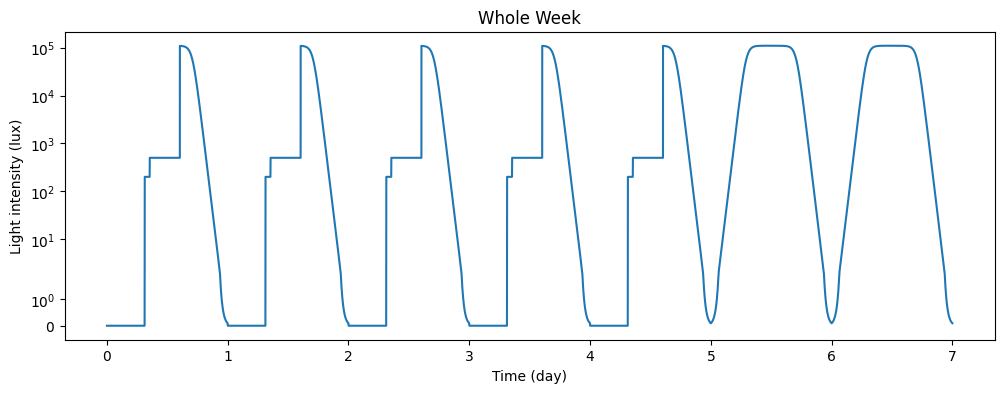

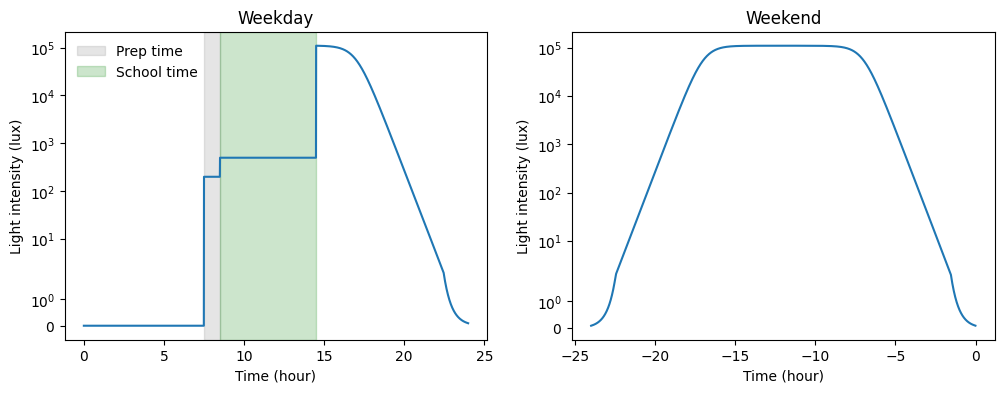

In [ ]:
#@title Debug getting light parameters
dt = 0.01 # hours
weeks = 1
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0
location = "New York"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_start_time': school_start_time,
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

school_schedule = LightSchedule.School(**light_schedule_parameters)
school_light = school_schedule(time)

weekday_mask = (time >= 0) & (time < 24)
wekkend_mask = (time >= 24*5) & (time < 24*6)

whole_week_fig = plt.figure(figsize=(12, 4))
whole_week_ax = whole_week_fig.add_subplot(111)
whole_week_ax.plot(time / 24.0, school_light, label='School Light Schedule')
whole_week_ax.set_yscale('symlog')
whole_week_ax.set_xlabel('Time (day)')
whole_week_ax.set_ylabel('Light intensity (lux)')
whole_week_ax.set_title('Whole Week')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time[weekday_mask], school_light[weekday_mask])
ax[0].set_yscale('symlog')
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Light intensity (lux)')
ax[0].set_title('Weekday')
ax[0].axvspan(school_start_time - prep_time, school_start_time, color='gray', alpha=0.2,
              edgecolor=None, label='Prep time')
ax[0].axvspan(school_start_time, school_start_time + school_duration, color='green', alpha=0.2,
              edgecolor=None, label='School time')
ax[0].legend(frameon=False)

ax[1].plot(time[wekkend_mask] - 24 * 6, school_light[wekkend_mask], label='Weekend')
ax[1].set_yscale('symlog')
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Light intensity (lux)')
ax[1].set_title('Weekend')

plt.show()


## Running a single simulation

In [ ]:
#@title Debug running a single simulation
dt = 0.01 # hours
weeks = 4
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0
location = "Chronia"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_start_time': school_start_time,
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

school_schedule = LightSchedule.School(**light_schedule_parameters)
school_light = school_schedule(time)

parameters = {
        'S0': 0,
        'forced_wakeup_light_threshold': 100.0, # half the default prep time lux
        'forced_wakeup_weekday_only': True,
}

model = Skeldon23(params=parameters)
trajectory = model.integrate(time, input=school_light)

sleep = model.sleep_state
circadian_state = trajectory.states[:, 0]
sleep_homeostat = trajectory.states[:, 3]
H_plus, H_minus = H_thresholds(model, trajectory)

fig, ax = plt.subplots(4, 1, figsize=(20, 8), sharex=True)

ax[0].plot(time, school_light, label='Light')
ax[0].axhline(model.forced_wakeup_light_threshold, color='r', linestyle='--', label='Forced wakeup threshold',
              alpha=0.5, zorder=-1)
ax[0].set_yscale('symlog')
ax[0].set_ylim(-1, 5.0 * lux_params["direct_sunlight_lux"])
ax[0].set_xlim(0, 24*7*weeks)
ax[0].set_ylabel('Light intensity (lux)')

ax[1].plot(time, circadian_state, label='Circadian state')
ax[1].set_ylabel('Circadian state')

ax[2].plot(time, sleep_homeostat, label='Sleep homeostat')
ax[2].plot(time, H_plus, label='H+')
ax[2].plot(time, H_minus, label='H-')
ax[2].set_ylabel('Homeostat & Thresholds')

ax[3].plot(time, sleep, label='Sleep state')
ax[3].set_ylabel('Sleep state')
ax[3].set_xlabel('Time (hour)')

plt.tight_layout()
plt.show()

## Multiple school start times

In [ ]:
#@title Debug running multiple simulations

location = "New York"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

school_start_times = np.array([6, 7, 8, 9, 10, 11, 12], dtype=float)

dt = 0.01 # hours
weeks = 4
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

parameters = {
        'S0': 0,
        'forced_wakeup_light_threshold': 100.0, # half the default prep time lux
        'forced_wakeup_weekday_only': True,
}


results = {
    'model': [],
    'trajectory': [],
    'light': [],
    'sleep': [],
}

for school_start_time in school_start_times:
    print(f'School start time: {school_start_time}')
    school_schedule = LightSchedule.School(school_start_time=school_start_time,
                                           **light_schedule_parameters)
    # Equilibrate for two weeks
    equilibration_model = Skeldon23(params=parameters)
    equilibration_time = np.arange(0, 24*7, dt) # one week
    equilibration_light = school_schedule(equilibration_time)
    initial_condition = model.equilibrate(equilibration_time, equilibration_light,
                                          num_loops=2) # two loops
    # Simulate
    simulation_parameters = parameters.copy()
    simulation_parameters['S0'] = equilibration_model.sleep_state[-1]
    model = Skeldon23(params=simulation_parameters)
    school_light = school_schedule(time)
    trajectory = model.integrate(time, input=school_light, initial_condition=initial_condition)

    results['model'].append(model)
    results['trajectory'].append(trajectory)
    results['light'].append(school_light)
    results['sleep'].append(model.sleep_state)

School start time: 6.0


/home/arcascope/when_should_school_start/.venv/lib/python3.12/site-packages/circadian/models.py:431: UserWarning: The model did not equilibrate. Try increasing the number of loops.
  warnings.warn("The model did not equilibrate. Try increasing the number of loops.")


School start time: 7.0
School start time: 8.0
School start time: 9.0
School start time: 10.0
School start time: 11.0
School start time: 12.0


In [ ]:
#@title Debug gathering data and plotting states for multiple simulations
plot_each_solution = False

average_sleep_duration = []
average_sleep_weekday = []
average_sleep_weekend = []

for i, (model, trajectory, school_light, sleep) in enumerate(zip(results['model'], results['trajectory'], results['light'], results['sleep'])):
    print(f'School start time: {school_start_times[i]}')
    circadian_state = trajectory.states[:, 0]
    sleep_homeostat = trajectory.states[:, 3]
    H_plus, H_minus = H_thresholds(model, trajectory)

    # Calculate sleep metrics
    sleep_onset, sleep_offset = calculate_sleep_onset_and_offset(time, sleep)
    sleep_duration = calculate_sleep_duration(time, sleep)

    weekday_sleep_duration = []
    weekend_sleep_duration = []
    for idx, onset in enumerate(sleep_onset):
        if (onset / 24.0) % 7 < 5:
            weekday_sleep_duration.append(sleep_duration[idx])
        else:
            weekend_sleep_duration.append(sleep_duration[idx])

    average_sleep_duration.append(np.mean(sleep_duration))
    average_sleep_weekday.append(np.mean(weekday_sleep_duration))
    average_sleep_weekend.append(np.mean(weekend_sleep_duration))

    if plot_each_solution:
        fig, ax = plt.subplots(4, 1, figsize=(20, 8))#, sharex=True)

        ax[0].plot(time, school_light, label='Light')
        ax[0].axhline(model.forced_wakeup_light_threshold, color='r', linestyle='--', label='Forced wakeup threshold')
        ax[0].set_yscale('symlog')
        ax[0].set_ylim(-1, 2.0 * school_light.max())
        # ax[0].set_xlim(0, 24*7)
        # ax[0].set_xlim(24*7*weeks-24*7, 24*7*weeks)

        ax[1].plot(time, circadian_state, label='Circadian state')

        ax[2].plot(time, sleep_homeostat, label='Sleep homeostat')
        ax[2].plot(time, H_plus, label='H+')
        ax[2].plot(time, H_minus, label='H-')

        ax[3].plot(time, sleep, label='Sleep state')

        plt.tight_layout()
        plt.show()

School start time: 6.0
School start time: 7.0
School start time: 8.0
School start time: 9.0
School start time: 10.0
School start time: 11.0
School start time: 12.0


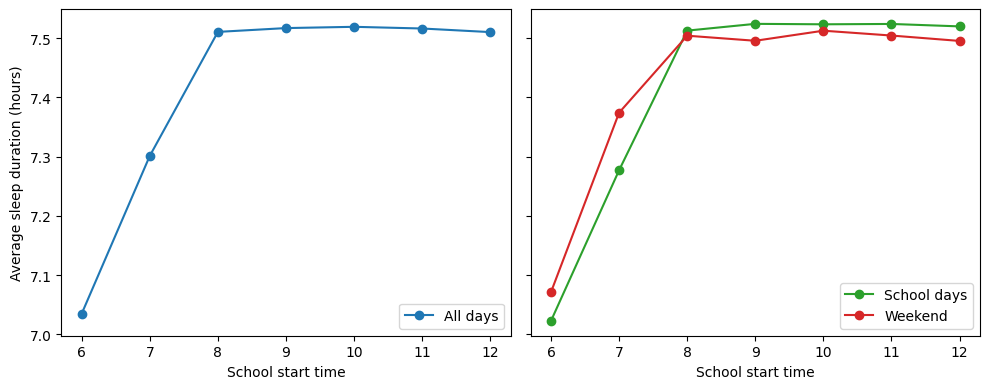

In [ ]:
#@title Debug plotting average sleep metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

ax[0].plot(school_start_times, average_sleep_duration, '-o', label='All days',
           color='tab:blue')
ax[0].set_xlabel('School start time')
ax[0].set_ylabel('Average sleep duration (hours)')
ax[0].legend(loc='lower right')

ax[1].plot(school_start_times, average_sleep_weekday, '-o', label='School days',
           color='tab:green')
ax[1].plot(school_start_times, average_sleep_weekend, '-o', label='Weekend',
           color='tab:red')
ax[1].set_xlabel('School start time')
ax[1].legend()

plt.tight_layout()
plt.show()